In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# activation.py
def sigmoid(x, derivative=False):
    if derivative:
        return np.exp(x) / ((1 + np.exp(x)) ** 2)
    return 1/(1+np.exp(-x))

In [3]:
# utils.py
def scale(X):
    return (X-np.mean(X, 0))/np.std(X, 0)

def shuffle_data(x, y):
    t = np.arange(x.shape[0])
    np.random.shuffle(t)
    return x[t], y[t]

def split_batches(x, y, bs):
    batch_nr = np.shape(x)[0]//bs
    batch_x = np.array_split(x, batch_nr)
    batch_y = np.array_split(y, batch_nr)
    return batch_x, batch_y

In [10]:
# evaluation.py
def MSE(x, y):
    return np.mean((x - y) ** 2)

In [12]:
class MLP:
    def __init__(self, layers, act_fn, batch_size, epoq, eta=0.01, alpha=0.9, bias=True, regression=True):
        '''
        layers - a list of int-s, i-th place corresponds to i-th layer size, including input and output layers
        epoq - # of epoques
        eta - learning rate
        alpha - momentum rate, when equal to 0 it's inactive
        bias, regression take boolean values
        '''
        self.af = act_fn
        self.bias = bias
        self.bs = batch_size
        self.epoq = epoq
        self.eta = eta
        self.alpha = alpha
        self.regr = regression
        
        # initialize weights randomly
        if self.bias:
            self.W = [np.random.rand(layers[i-1]+1, layers[i]) for i in range(1, len(layers))]
        else:
            self.W = [np.random.rand(layers[i-1], layers[i]) for i in range(1, len(layers))]
        
        # derivatives of weights
        self.dW = [np.zeros_like(w) for w in self.W]
        
        # momentum
        self.mW = [np.zeros_like(w) for w in self.W]
        
    
    def forward(self, x): 
        z = [0]*len(self.W)
        for i in range(len(self.W)):
            z[i] = np.c_[x, np.ones(x.shape[0])] @ self.W[i]
            x = self.af(z[i])    
        return z
    
    
    def backprop(self, x, y):
        for j in range(self.epoq):
            x, y = shuffle_data(x, y)
            batch_x, batch_y = split_batches(x, y, self.bs)
            
            for b_x, b_y in zip(batch_x, batch_y):
                z = self.forward(b_x)
                e = z[-1] - b_y
                for i in reversed(range(len(self.W)-1)):
                    self.dW[i+1] = (np.c_[self.af(z[i]), np.ones(z[i].shape[0])].T @ e)/z[i].shape[0]
                    if i != 0:
                        e =  e @ self.W[i+1][:-1,:].T * self.af(z[i], True)
                        
                for i in range(len(self.W)):
                    self.mW[i] = self.alpha * self.mW[i] + (1-self.alpha) * self.dW[i]
                    self.W[i] -= self.eta * self.mW[i]
                        
    # to do: classification, forward and backprop without bias
    # can we assume last hidden layer has sigmoid activation function always? That allows for e = z[-1] - b_y

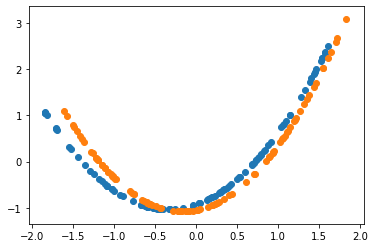

In [5]:
from numpy import genfromtxt

# import train data
path = '/Users/Gonia_Wachulec/Desktop/Python/MIO/mio1/regression/square-simple-training.csv'
data = scale(np.genfromtxt(path, delimiter=',')[1:, 1:])
X_train = data[:,0].reshape(-1,1)
Y_train = data[:,1].reshape(-1,1)
plt.scatter(X_train, Y_train) # it's scaled

# import test data
path = '/Users/Gonia_Wachulec/Desktop/Python/MIO/mio1/regression/square-simple-test.csv'
data = scale(np.genfromtxt(path, delimiter=',')[1:, 1:])
X_test = data[:,0].reshape(-1,1)
Y_test = data[:,1].reshape(-1,1)
plt.scatter(X_test, Y_test)

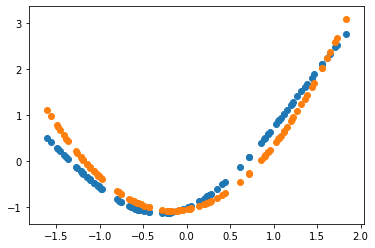

In [17]:
mlp = MLP([1,10,1],sigmoid,1,10000)
mlp.backprop(X_train,Y_train)
pred = mlp.forward(X_test)[-1]
plt.scatter(X_test, pred)
plt.scatter(X_test, Y_test)

In [18]:
print("MSE on test set: " + str(MSE(Y_test,pred)))

MSE on test set: 0.07432046194625724
